# TBD Phase 2: Performance & Computing Models

## Introduction
In this lab, you will compare the performance and computing models of four popular data processing engines: **Polars, Pandas, DuckDB, and PySpark**.

You will explore:
- **Performance**: Single-node processing speed, parallel execution, and memory usage.
- **Scalability**: How performance changes with the number of cores (single-node) and executors (cluster).
- **Computing Models**: Out-of-core vs. In-memory processing, and Eager vs. Lazy execution.

### Engine Capabilities
The following table summarizes the key capabilities of the engines we will be testing. Use this as a reference.

| Engine | Query Optimizer | Distributed | Arrow-backed | Out-of-Core | Parallel | APIs | GPU Support |
|---|---|---|---|---|--|---|---|
| **Pandas** | ❌ | ❌ | optional ≥ 2.0 | ❌ | ❌ | DataFrame | ❌ |
| **Polars** | ✅ | ❌ | ✅ | ✅ | ✅ | DataFrame | ✅ (opt) |
| **PySpark** | ✅ | ✅ | Pandas UDF/IO | ✅ | ✅ | SQL, DataFrame | ❌ (no GPU) |
| **DuckDB** | ✅ | ❌ | ✅ | ✅ | ❌ | SQL, Relational API | ❌ |

## Prerequisites
Ensure you have the necessary libraries installed.

In [1]:
%pip install polars pandas duckdb pyspark faker deltalake memory_profiler pyarrow matplotlib

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import polars as pl
import pandas as pd
import duckdb
from pyspark.sql import SparkSession
from faker import Faker
import numpy as np
import os
import time
import psutil
from memory_profiler import memory_usage

# Initialize Spark (Single Node)
spark = SparkSession.builder \
    .appName("BigDataLab2") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/08 19:31:23 WARN Utils: Your hostname, pepinosdev, resolves to a loopback address: 127.0.1.1; using 192.168.1.43 instead (on interface enp5s0)
26/01/08 19:31:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/08 19:31:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Part 1: Data Generation

We will generate a synthetic dataset simulating social media posts with a rich schema.

**Schema**:
- `post_id` (String): Unique identifier.
- `user_id` (Integer): User identifier.
- `timestamp` (DateTime): Time of post.
- `content` (String): Text content.
- `likes` (Integer): Number of likes.
- `views` (Integer): Number of views.
- `category` (String): Post category.
- `tags` (List[String]): Hashtags.
- `location` (String): User location.
- `device` (String): Device used (Mobile, Web, etc.).
- `latency` (Float): Network latency.
- `error_rate` (Float): Error rate during upload.

In [ ]:
def generate_data(num_records=1_000_000, output_path="social_media_data.parquet"):
    fake = Faker()

    print(f"Generating {num_records} records...")

    # Generate data using numpy for speed where possible
    data = {
        "post_id": [fake.uuid4() for _ in range(num_records)],
        "user_id": np.random.randint(1, 100_000, num_records),
        "timestamp": pd.date_range(start="2023-01-01", periods=num_records, freq="s").to_numpy().astype("datetime64[us]"),
        "likes": np.random.randint(0, 10_000, num_records),
        "views": np.random.randint(0, 1_000_000, num_records),
        "category": np.random.choice(["Tech", "Health", "Travel", "Food", "Fashion", "Politics", "Sports"], num_records),
        "tags": [np.random.choice(["#viral", "#new", "#trending", "#hot", "#update"], size=np.random.randint(1, 4)).tolist() for _ in range(num_records)],
        "location": np.random.choice(["USA", "UK", "DE", "PL", "FR", "JP", "BR"], num_records),
        "device": np.random.choice(["Mobile", "Desktop", "Tablet"], num_records),
        "latency": np.random.uniform(10.0, 500.0, num_records),
        "error_rate": np.random.beta(1, 10, num_records),
        "content": [fake.sentence() for _ in range(min(num_records, 1000))] * (num_records // 1000 + 1)
    }

    # Trim to exact size
    data["content"] = data["content"][:num_records]

    df = pd.DataFrame(data)

    print("Writing to Parquet...")
    df.to_parquet(output_path, engine="pyarrow")
    print(f"Data saved to {output_path}")

# Generate 5 million records
generate_data(num_records=5_000_000)

Generating 5000000 records...
Writing to Parquet...
Data saved to social_media_data.parquet


## Part 2: Measuring Performance

### 2.1 Execution Time
Use `%time` or `%timeit` to measure execution time.

In [4]:
# Example: Measuring time for all engines
print("--- Performance Benchmark Example ---")

# Pandas
print("Pandas Load Time:")
%time df_pd = pd.read_parquet("social_media_data.parquet")

# Polars
print("\nPolars Load Time:")
%time df_pl = pl.read_parquet("social_media_data.parquet")

# DuckDB
print("\nDuckDB Query Time:")
%time duckdb.sql("SELECT count(*) FROM 'social_media_data.parquet'").show()

# PySpark
print("\nSpark Load Time:")
%time df_spark = spark.read.parquet("social_media_data.parquet"); df_spark.count()

--- Performance Benchmark Example ---
Pandas Load Time:
CPU times: user 3.3 s, sys: 1.61 s, total: 4.91 s
Wall time: 3.13 s

Polars Load Time:
CPU times: user 680 ms, sys: 400 ms, total: 1.08 s
Wall time: 256 ms

DuckDB Query Time:
┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      5000000 │
└──────────────┘

CPU times: user 3.02 ms, sys: 3.09 ms, total: 6.11 ms
Wall time: 4.38 ms

Spark Load Time:
CPU times: user 3.82 ms, sys: 5.01 ms, total: 8.83 ms
Wall time: 2.2 s


5000000

## Part 3: Student Tasks

### Task 1: Performance & Scalability (Single Node)

**Goal**: Benchmark the engines and test how they scale with available CPU cores.

**Instructions**:
1.  **Define Queries**: Create 3 distinct queries of your own choice. They should cover:
    -   **Query A**: A simple aggregation (e.g., grouping by a categorical column and calculating means).
    -   **Query B**: A window function or more complex transformation.
    -   **Query C**: A join (e.g., self-join or join with a smaller generated table) with filtering.
2.  **Benchmark**: Implement these queries in **Pandas, Polars, DuckDB, and PySpark**.
    -   Measure **Execution Time** using `%time` or `time.time()`.
    -   Measure **Peak Memory** usage using `memory_profiler` (e.g., `memory_usage()`).
3.  **Scalability Test**: 
    -   Select **all engines** that support parallel execution on a single node (e.g., Polars, DuckDB).
    -   Run **all 3 queries** with different numbers of threads/cores (e.g., 1, 2, 4, 8).
    -   Plot the speedup for each query and engine.

**Tip**: 
-   Polars: [polars.thread_pool_size](https://docs.pola.rs/api/python/stable/reference/api/polars.thread_pool_size.html) Please also note that *Thread configuration in Polars requires process restart*
-   DuckDB: `PRAGMA threads=n`
-   Spark: `master="local[n]"`

## Defined Queries
- Query A (Aggregation): Group by 'category' and calculate mean of 'likes' and 'latency'
- Query B (Window Function): Calculate a "Rolling Average of Views" (window size 3) partitioned by 'category' and ordered by 'timestamp'.
- Query C (Join & Filter): Count users who post from different devices in the span of 60 seconds

## Additional imports

In [5]:
import gc
from pyspark.sql import DataFrame as pysparkDataframe
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.window import Window
PARQUET_FILE = "social_media_data.parquet"

## Querries implementation

In [ ]:
def run_pandas(df: pd.DataFrame, query_type: str) -> pd.DataFrame:

    # Run explicit garbage collections to ensure fair benchmarking
    gc.collect()

    if query_type == 'A':
        return df.groupby('category')[['likes', 'latency']].mean()

    elif query_type == 'B':
        return df.groupby('category')['views'].rank(method='dense', ascending=False)

    elif query_type == 'C':

        df_C = df.sample(frac=0.1) # This query causes OOM (32GB is not enough)

        merged = df_C.merge(df_C, on='user_id', suffixes=('_1', '_2'))
        merged = merged[merged["device_1"] != merged["device_2"]]
        time_diff = (merged["timestamp_1"] - merged["timestamp_2"]).abs()
        merged = merged[time_diff < pd.Timedelta(seconds=60)]
        return merged.groupby('category_1')['post_id_1'].count()

    else:
        raise ValueError('Wrong query_type. Choose between A, B and C')

### Queries implementation with Polars is in polars_worker.py
Number of available cores to use by Polars is defined before importing Polars module - it is read from enviromental variable 'POLARS_MAX_THREADS'. Reseting environmental variable (os.environ['POLARS_MAX_THREADS']) in benchmark loop does not cause Polars engine to use more cores. To solve this issue we write Polars queries in seperate script - polars_worker.py and we run it in notebook in new process for each 'core' value.

In [ ]:
%%writefile polars_worker.py
import argparse
import os
import time
import gc
from memory_profiler import memory_usage

parser = argparse.ArgumentParser()
parser.add_argument("--cores", type=str, required=True)
parser.add_argument("--query", type=str, required=True)
parser.add_argument("--file", type=str, required=True)
args = parser.parse_args()

# Set Environment Variable BEFORE importing Polars
os.environ["POLARS_MAX_THREADS"] = args.cores

import polars as pl

def run_polars_query(parquet_file, query_type):
    lazy_df = pl.scan_parquet(parquet_file)

    if query_type == 'A':
        return lazy_df.group_by("category").agg([
            pl.col("likes").mean(),
            pl.col("latency").mean()
        ]).collect()

    elif query_type == 'B':
        return lazy_df.with_columns(
            pl.col("views")
            .rank("dense", descending=True)
            .over("category")
            .alias("rank")
        ).collect()

    elif query_type == 'C':

        lazy_df_c = lazy_df.filter((pl.col("user_id") % 10) == 0)

        q1 = lazy_df_c.select(["user_id", "post_id", "timestamp", "device", "category"])
        q2 = lazy_df_c.select([
            pl.col("user_id"),
            pl.col("post_id").alias("post_id_2"),
            pl.col("timestamp").alias("timestamp_2"),
            pl.col("device").alias("device_2")
        ])

        return (q1.join(q2, on="user_id")
                .filter(pl.col("device") != pl.col("device_2"))
                .filter((pl.col("timestamp") - pl.col("timestamp_2")).abs() < pl.duration(seconds=60))
                .group_by("category")
                .agg(pl.count("post_id"))
                .collect())

def wrapper():
    gc.collect()
    run_polars_query(args.file, args.query)

try:
    # Time Measurement
    start_time = time.time()
    wrapper()
    duration = time.time() - start_time

    # Peak Memory Measurement
    try:
        mem_usage = memory_usage(wrapper, interval=0.1, timeout=None)
        peak_mem = max(mem_usage)
    except:
        peak_mem = 0.0

    print(f"RESULT|{duration}|{peak_mem}")

except Exception as e:
    print(f"ERROR|{e}")

Overwriting polars_worker.py


In [ ]:
def run_duckdb(con: duckdb.DuckDBPyConnection, query_type: str):

    if query_type == 'A':
        return con.execute(f"""
            SELECT AVG(likes), AVG(latency)
            FROM '{PARQUET_FILE}'
            GROUP BY category
        """).fetchall()

    elif query_type == 'B':
        return con.execute(f"""
            SELECT post_id, DENSE_RANK() OVER (PARTITION BY category ORDER BY views DESC)
            FROM '{PARQUET_FILE}'
        """).fetchall()

    elif query_type == 'C':
        return con.execute(f"""
            SELECT t1.category, COUNT(t1.post_id)
            FROM '{PARQUET_FILE}' t1
            JOIN '{PARQUET_FILE}' t2 ON t1.user_id = t2.user_id
            WHERE t1.post_id != t2.post_id
                AND t1.device != t2.device
                AND abs(date_diff('second', t1.timestamp, t2.timestamp)) < 60
            GROUP BY t1.category
        """).fetchall()

    else:
        raise ValueError('Wrong query_type. Choose between A, B and C')

In [ ]:
def run_spark(df: pysparkDataframe, query_type: str):

    if query_type == 'A':
        return df.groupBy("category").agg(F.mean("likes"), F.mean("latency")).collect()

    elif query_type == 'B':
        w = Window().partitionBy("category").orderBy(F.col("views").desc())
        df.withColumn("rank", F.rank().over(w)).write.format("noop").mode("overwrite").save()
        return True

    elif query_type == 'C':
        df1 = df.alias("df1")
        df2 = df.alias("df2")
        return (df1.join(df2, F.col("df1.user_id") == F.col("df2.user_id"))
                .filter(F.col("df1.post_id") != F.col("df2.post_id"))
                .filter(F.col("df1.device") != F.col("df2.device"))
                .filter(F.abs(F.col("df1.timestamp").cast("timestamp").cast("long") - F.col("df2.timestamp").cast("timestamp").cast("long")) < 60)
                .groupBy("df1.category")
                .count().write.format("noop").mode("overwrite").save())

    else:
        raise ValueError ('Wrong query_type. Choose between A, B and C')

## Benchmark functions

Seperate function for Polars benchmarking - running in subprocesses

In [ ]:
import subprocess
import sys
def run_polars(engine_name, cores, query_types):
    results = []
    for q in query_types:
        print(f"  Running Query {q}...", end=" ", flush=True)
        try:
            cmd = [
                sys.executable, "polars_worker.py",
                "--cores", str(cores),
                "--query", q,
                "--file", PARQUET_FILE
            ]

            result = subprocess.run(cmd, capture_output=True, text=True)

            output_lines = result.stdout.strip().split('\n')
            result_line = [line for line in output_lines if line.startswith("RESULT|")]

            if result_line:
                _, duration_str, peak_mem_str = result_line[0].split("|")
                duration, peak_mem = float(duration_str), float(peak_mem_str)

                print(f"Time: {duration:.2f}s | Peak Mem: {peak_mem:.0f} MB")
                results.append({
                    'Engine': engine_name,
                    'Cores': cores,
                    'Query': q,
                    'Time_s': duration,
                    'Memory_MB': peak_mem
                })
            else:
                raise Exception(f"Worker failed or produced no output. Stderr: {result.stderr}")

        except Exception as e:
            print(f"FAILED: {e}")
            results.append({'Engine': engine_name, 'Cores': cores, 'Query': q, 'Time_s': None, 'Memory_MB': 0})

In [ ]:

def benchmark_engine(engine_name, cores, query_types=['A', 'B', 'C']):
    print(f"--- Benchmarking {engine_name} [{cores} cores] ---")

    # run polars queries in new processes
    if engine_name == 'Polars':
        results = run_polars(engine_name, cores, query_types)
        return results

    results = []
    if engine_name == 'Pandas':
        df = pd.read_parquet(PARQUET_FILE)
        args = [df]
        wrapper = run_pandas

    elif engine_name == 'DuckDB':
        con = duckdb.connect(':memory:')
        con.execute(f"PRAGMA threads={cores}")
        args = [con]
        wrapper = run_duckdb

    elif engine_name == 'Spark':
        spark = SparkSession.builder.master(f"local[{cores}]") \
                    .appName("Bench") \
                    .config("spark.driver.memory", "4g") \
                    .getOrCreate()
        spark.sparkContext.setLogLevel("ERROR")
        df = spark.read.parquet(PARQUET_FILE)
        args = [df]
        wrapper = run_spark

    for q in query_types:
        print(f"  Running Query {q}...", end=" ", flush=True)
        try:
            gc.collect()
            t_start = time.time()
            wrapper(*args, q)
            duration = time.time() - t_start

            mem_usage_log = memory_usage((wrapper, args, {'query_type': q}), interval=0.1, timeout=None)
            peak_mem = max(mem_usage_log)

            print(f"Time: {duration:.2f}s | Peak Mem: {peak_mem:.0f} MB")

            results.append({
                'Engine': engine_name,
                'Cores': cores,
                'Query': q,
                'Time_s': duration,
                'Memory_MB': peak_mem
            })
        except Exception as e:
            print(f"FAILED: {e}")
            results.append({'Engine': engine_name, 'Cores': cores, 'Query': q, 'Time_s': None, 'Memory_MB': 0})

    # Teardown
    if engine_name == 'Spark':
        spark.stop()
    elif engine_name == 'Pandas':
        del df, args
        gc.collect()
    elif engine_name == 'DuckDB':
        con.close()

    return results

## Run Benchmark

In [ ]:
all_results = []
core_counts = [1, 2, 4, 8]

# Baseline - 1 core only needed as it doesn't scale
print("\nRunning Pandas Baseline...")
all_results.extend(benchmark_engine('Pandas', 1))

# Scalable Engines
for engine in ['Polars', 'DuckDB', 'Spark']:
    for c in core_counts:
        all_results.extend(benchmark_engine(engine, c))


Running Pandas Baseline...
--- Benchmarking Pandas [1 cores] ---
  Running Query A... Time: 0.24s | Peak Mem: 5450 MB
  Running Query B... Time: 1.54s | Peak Mem: 5665 MB
  Running Query C... Time: 2.01s | Peak Mem: 6579 MB
--- Benchmarking Polars [1 cores] ---
  Running Query A... Time: 0.16s | Peak Mem: 287 MB
  Running Query B... Time: 1.18s | Peak Mem: 1608 MB
  Running Query C... Time: 1.68s | Peak Mem: 3500 MB
--- Benchmarking Polars [2 cores] ---
  Running Query A... Time: 0.11s | Peak Mem: 301 MB
  Running Query B... Time: 0.78s | Peak Mem: 1734 MB
  Running Query C... Time: 1.01s | Peak Mem: 3475 MB
--- Benchmarking Polars [4 cores] ---
  Running Query A... Time: 0.07s | Peak Mem: 323 MB
  Running Query B... Time: 0.51s | Peak Mem: 1806 MB
  Running Query C... Time: 0.59s | Peak Mem: 3883 MB
--- Benchmarking Polars [8 cores] ---
  Running Query A... Time: 0.07s | Peak Mem: 355 MB
  Running Query B... Time: 0.43s | Peak Mem: 1870 MB
  Running Query C... Time: 0.83s | Peak Mem:

26/01/08 19:34:25 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Time: 0.80s | Peak Mem: 3996 MB
  Running Query B... 

Time: 5.43s | Peak Mem: 3996 MB
  Running Query C... 

Time: 8.68s | Peak Mem: 3996 MB
--- Benchmarking Spark [2 cores] ---
  Running Query A... Time: 0.41s | Peak Mem: 3996 MB
  Running Query B... 

Time: 9.36s | Peak Mem: 3996 MB
  Running Query C... 

Time: 15.88s | Peak Mem: 3996 MB
--- Benchmarking Spark [4 cores] ---
  Running Query A... Time: 0.35s | Peak Mem: 3995 MB
  Running Query B... 

Time: 6.20s | Peak Mem: 3995 MB
  Running Query C... 

Time: 10.97s | Peak Mem: 3995 MB
--- Benchmarking Spark [8 cores] ---
  Running Query A... Time: 0.28s | Peak Mem: 3995 MB
  Running Query B... 

Time: 4.59s | Peak Mem: 3995 MB
  Running Query C... 

Time: 9.54s | Peak Mem: 3995 MB


## Scalability Analysis

Speed up is calculated with formula \
Time_1_core / Time_N_cores

In [ ]:
df_res = pd.DataFrame(all_results)
df_res['Speedup'] = 0.0

for engine in df_res['Engine'].unique():
    for q in df_res['Query'].unique():

        baseline_row = df_res[(df_res['Engine'] == engine) & (df_res['Query'] == q) & (df_res['Cores'] == 1)]

        if not baseline_row.empty and pd.notna(baseline_row['Time_s'].values[0]):
            base_time = baseline_row['Time_s'].values[0]

            mask = (df_res['Engine'] == engine) & (df_res['Query'] == q)
            df_res.loc[mask, 'Speedup'] = base_time / df_res.loc[mask, 'Time_s']

print("\n--- FINAL SUMMARY (With Speedup) ---")
print(df_res[['Engine', 'Cores', 'Query', 'Time_s', 'Speedup']])


--- FINAL SUMMARY (With Speedup) ---
    Engine  Cores Query     Time_s   Speedup
0   Pandas      1     A   0.243154  1.000000
1   Pandas      1     B   1.538649  1.000000
2   Pandas      1     C   2.006018  1.000000
3   Polars      1     A   0.159216  1.000000
4   Polars      1     B   1.184479  1.000000
5   Polars      1     C   1.679864  1.000000
6   Polars      2     A   0.107526  1.480718
7   Polars      2     B   0.775628  1.527123
8   Polars      2     C   1.011846  1.660197
9   Polars      4     A   0.070589  2.255528
10  Polars      4     B   0.512696  2.310294
11  Polars      4     C   0.588603  2.853984
12  Polars      8     A   0.071404  2.229809
13  Polars      8     B   0.433457  2.732632
14  Polars      8     C   0.833499  2.015436
15  DuckDB      1     A   0.049239  1.000000
16  DuckDB      1     B   4.588005  1.000000
17  DuckDB      1     C   9.322104  1.000000
18  DuckDB      2     A   0.026119  1.885212
19  DuckDB      2     B   3.537973  1.296789
20  DuckDB      2

## Result plots

In [ ]:
import matplotlib.pyplot as plt

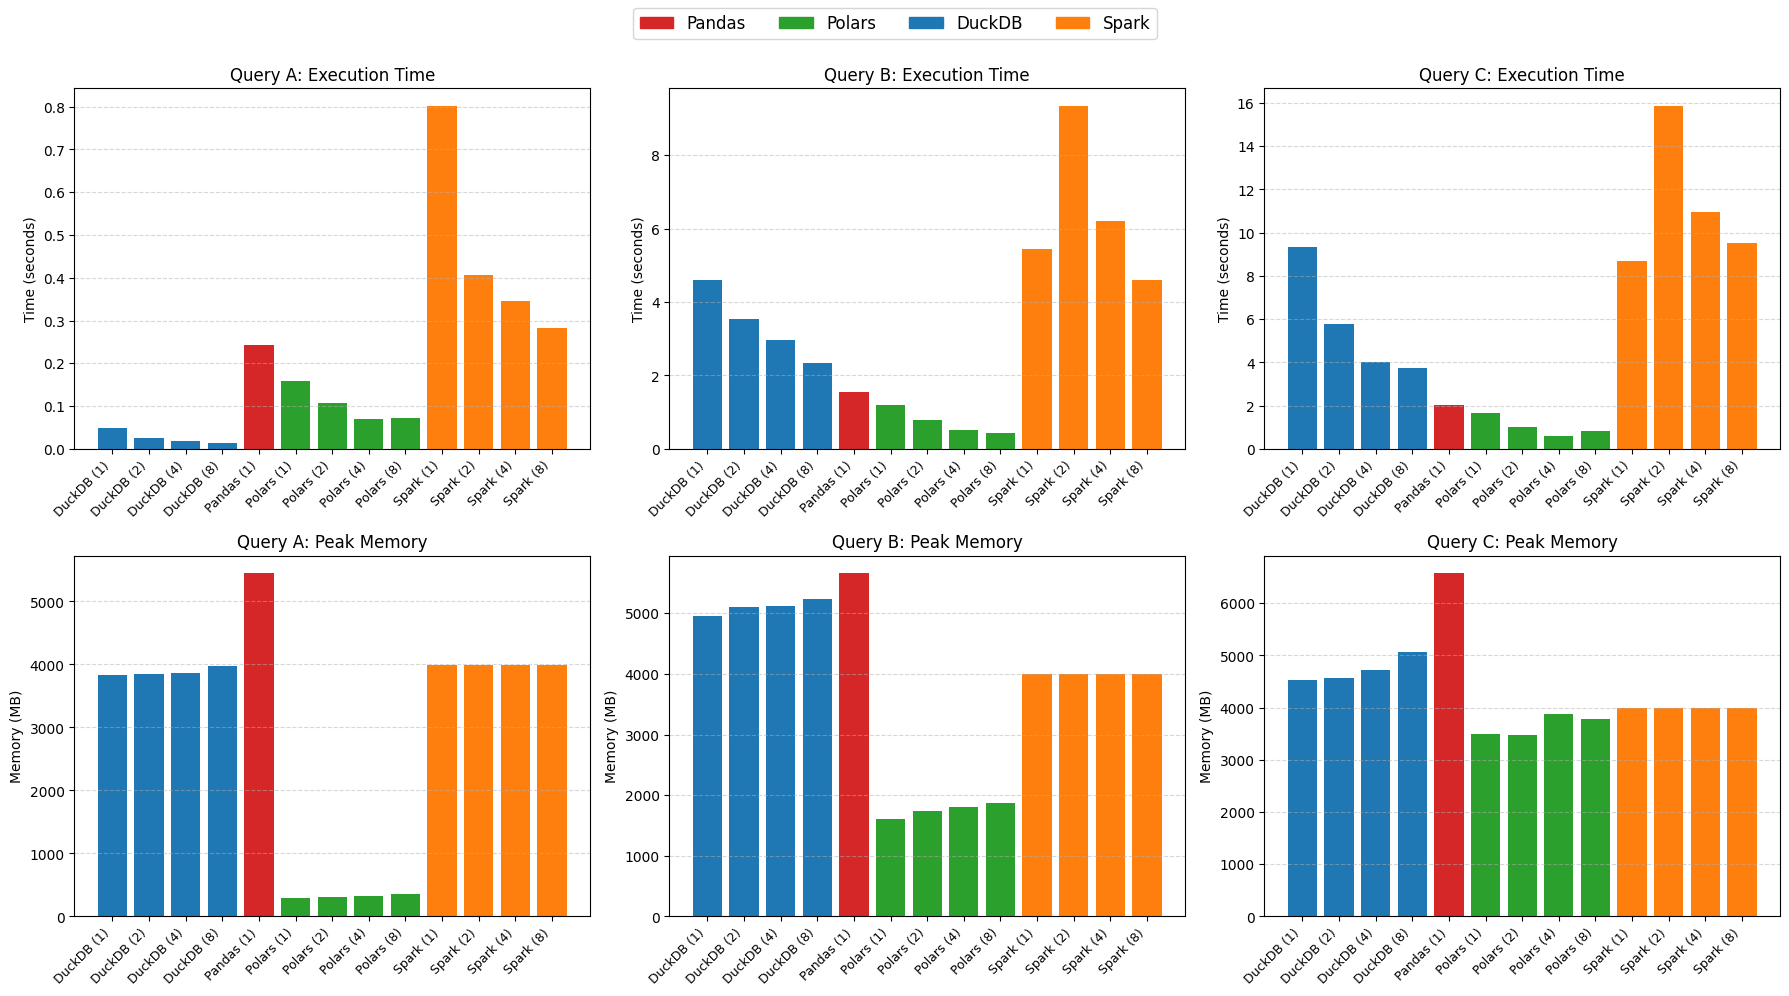

In [ ]:
def plot_benchmark_results(df_res):
    queries = df_res['Query'].unique()
    engines = df_res['Engine'].unique()

    fig, axes = plt.subplots(2, len(queries), figsize=(18, 10))

    colors = {'Pandas': 'tab:red', 'Polars': 'tab:green', 'DuckDB': 'tab:blue', 'Spark': 'tab:orange'}

    for i, q in enumerate(sorted(queries)):
        ax_time = axes[0, i]

        subset = df_res[df_res['Query'] == q].sort_values(['Engine', 'Cores'])

        labels = subset.apply(lambda x: f"{x['Engine']} ({x['Cores']})", axis=1)
        x_pos = np.arange(len(labels))

        ax_time.bar(x_pos, subset['Time_s'], color=[colors[e] for e in subset['Engine']])

        ax_time.set_title(f"Query {q}: Execution Time")
        ax_time.set_ylabel("Time (seconds)")
        ax_time.set_xticks(x_pos)
        ax_time.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
        ax_time.grid(axis='y', linestyle='--', alpha=0.5)

        # Optional: Add Log Scale if disparities are huge (e.g. 0.05s vs 5.0s)
        # ax_time.set_yscale('log')

        ax_mem = axes[1, i]

        ax_mem.bar(x_pos, subset['Memory_MB'], color=[colors[e] for e in subset['Engine']])

        ax_mem.set_title(f"Query {q}: Peak Memory")
        ax_mem.set_ylabel("Memory (MB)")
        ax_mem.set_xticks(x_pos)
        ax_mem.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
        ax_mem.grid(axis='y', linestyle='--', alpha=0.5)

    handles = [plt.Rectangle((0,0),1,1, color=colors[e]) for e in engines]
    fig.legend(handles, engines, loc='upper center', ncol=len(engines), fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to make room for legend
    plt.show()

plot_benchmark_results(df_res)

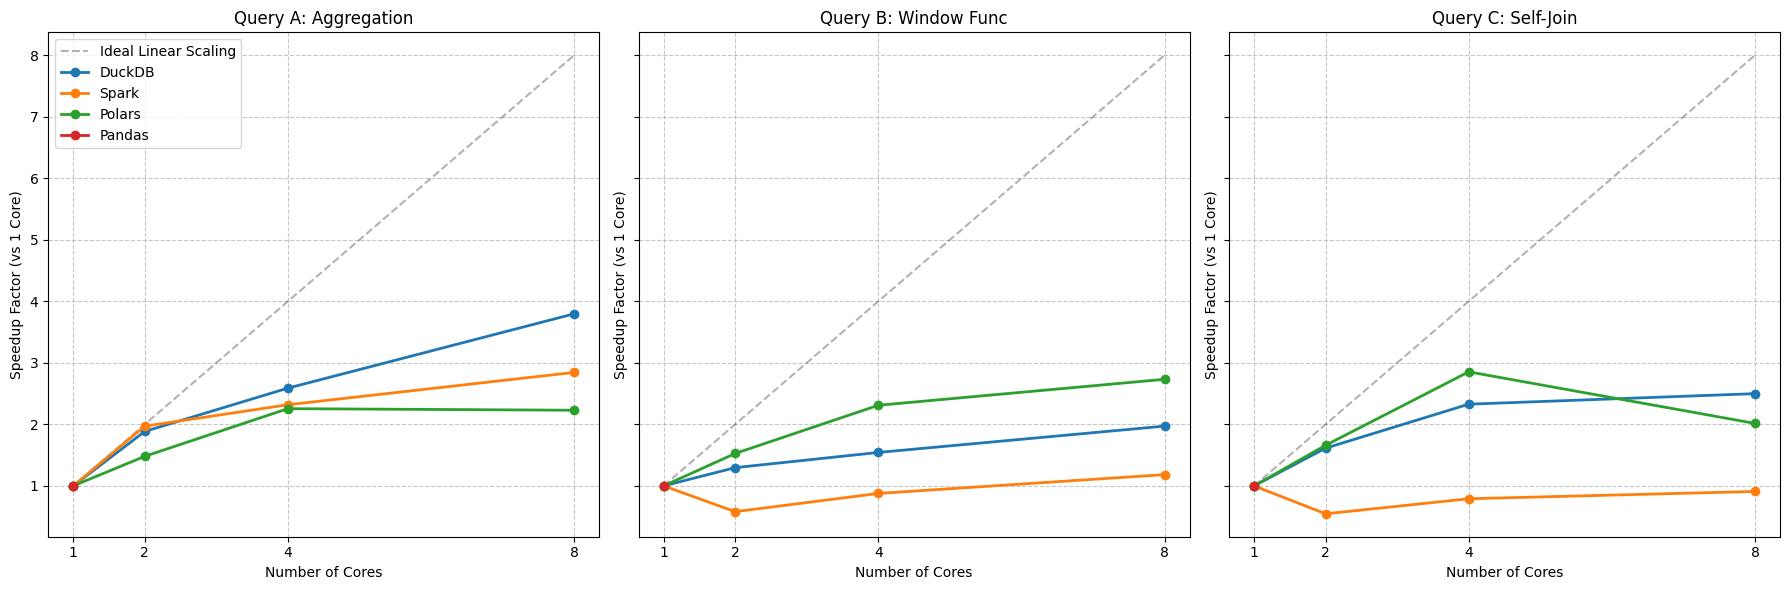

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
queries = ['A', 'B', 'C']
titles = ['Query A: Aggregation', 'Query B: Window Func', 'Query C: Self-Join']

for i, q in enumerate(queries):
    ax = axes[i]

    # Plot Ideal Scaling Reference
    ax.plot(core_counts, core_counts, 'k--', alpha=0.3, label='Ideal Linear Scaling')

    for engine in ['DuckDB', 'Spark', 'Polars', 'Pandas']:
        subset = df_res[(df_res['Engine'] == engine) & (df_res['Query'] == q)].sort_values('Cores')

        if not subset.empty and subset['Speedup'].max() > 0:
            ax.plot(subset['Cores'], subset['Speedup'], marker='o', linewidth=2, label=engine)

    ax.set_title(titles[i])
    ax.set_xlabel("Number of Cores")
    ax.set_ylabel("Speedup Factor (vs 1 Core)")
    ax.set_xticks(core_counts)
    ax.grid(True, linestyle='--', alpha=0.7)

    # Legend only on first plot to reduce clutter
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

### Task 2: Spark on Cluster

**Goal**: Compare Single Node performance vs. Spark on a Cluster.

**Instructions**:
1.  **Infrastructure**: Use the infrastructure from **Phase 1** (Google Dataproc). You may need to modify your Terraform code to adjust the cluster configuration (e.g., number of worker nodes).
2.  **Environment**: The easiest way to run this is via **Google Workbench** connected to your Dataproc cluster.
3.  **Upload Data**: Upload the generated `social_media_data.parquet` to HDFS or GCS.
    -   **Tip**: For better performance, consider **partitioning** the data (e.g., by `category` or `date`) when saving it to the distributed storage. This allows Spark to optimize reads.
4.  **Run Queries**: Run your PySpark queries from Task 1 on the cluster.
5.  **Scalability Test**: 
    -   Run the queries with different numbers of **worker nodes** (e.g., 2, 3, 4).
    -   You can achieve this by resizing the cluster (manually or via Terraform) or by configuring the number of executors in Spark.
6.  **Analyze**:
    -   How does the cluster performance compare to your local machine?
    -   Did adding more nodes/executors linearly improve performance?
    -   **Tip**: If Spark is slower than single-node engines, consider **increasing the dataset size** (e.g., generate 10M+ records or duplicate the data). Spark's overhead is significant for small data, and its true power appears when data exceeds single-node memory.

**Execution and results**
First, we've uploaded the social_media_data.parquet to GCS. We decided not to partition it, as to test spark's cluster performance without partitioning.
![Parquet on GCS](report/parquet_on_gcs.png)

We've created the following pyspark job for execution of the task on the cluster:

```python


import time
import sys
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.window import Window

def run_spark(df, query_type):
    if query_type == 'A':
        return df.groupBy("category").agg(F.mean("likes"), F.mean("latency")).collect()

    elif query_type == 'B':
        w = Window().partitionBy("category").orderBy(F.col("views").desc())
        df.withColumn("rank", F.rank().over(w)).write.format("noop").mode("overwrite").save()
        return True

    elif query_type == 'C':
        df1 = df.alias("df1")
        df2 = df.alias("df2")
        return (df1.join(df2, F.col("df1.user_id") == F.col("df2.user_id"))
                .filter(F.col("df1.post_id") != F.col("df2.post_id"))
                .filter(F.col("df1.device") != F.col("df2.device"))
                .filter(F.abs(F.col("df1.timestamp").cast("timestamp").cast("long") -
                              F.col("df2.timestamp").cast("timestamp").cast("long")) < 60)
                .groupBy("df1.category")
                .count()
                .write.format("noop").mode("overwrite").save())

    else:
        raise ValueError('Wrong query_type. Choose between A, B and C')

def main():
    spark = SparkSession.builder \
        .appName("SocialMediaAnalysis_Benchmark") \
        .getOrCreate()

    sc = spark.sparkContext
    executors = sc.getConf().get("spark.executor.instances", "dynamic")

    print(f"\n===== Rozpoczynam benchmark (Konfiguracja executors: {executors}) =====")

    data_path = "gs://tbd-2025z-318720-data/data/social_media_data.parquet"

    print(f"Wczytywanie danych z: {data_path}")
    df = spark.read.parquet(data_path)
    queries = ["A", "B", "C"]

    for query_type in queries:
        print(f"--- Uruchamianie zapytania {query_type} ---")
        start_time = time.time()

        try:
            run_spark(df, query_type)
            end_time = time.time()
            duration = end_time - start_time
            print(f"SUKCES: Czas wykonania zapytania {query_type}: {duration:.2f} sekund")
        except Exception as e:
            print(f"BŁĄD przy zapytaniu {query_type}: {str(e)}")

    print("===== Koniec benchmarku =====")
    spark.stop()

if __name__ == "__main__":
    main()
```

Which we've put on the cluster:
![Job on GCS](report/job_on_gcs.png)

We've run it for 2, 3 and 4 executors in Spark, using following command in Google Cloud Shell (we changed number of executors accordingly):
```
gcloud dataproc jobs submit pyspark gs://tbd-2025z-318720-code/social_media_analysis.py \ --cluster=tbd-cluster \ --region=europe-west1 \ --properties=spark.executor.instances=2,spark.executor.cores=2,spark.executor.memory=4G 
```

The results were as follows:

2 executors:

![Result for 2 executors](report/results_2_executors.png)

3 executors:

![Result for 3 executors](report/results_3_executors.png)

4 executors:

![Result for 4 executors](report/results_4_executors.png)

Results in tabular form:

| No. executors | Job A   | Job B   | Job C   |
| ------------- | ------- | ------- | ------- |
|   2           | 17.35s  | 34.36s  | 38.00s  |
|   3           | 16.58s  | 25.37s  | 36.72s  |
|   4           | 16.88s  | 25.64s  | 25.79s  |

Cluster performance was significantly slower than a tested local machine. For example, for Spark on local machine for job A for 8 cores the result was just 0.282s, whereas here it was more than 17 seconds for 2 executors. This was probably because of the dataset size, as due to cloud operation, data transfer and communication can be quite time consuming compared to local machine. Larger data set would most likely benefit the Cluster spark edition. Alternatively, our local machine might have been very powerful.

It can be seen that adding executors sped up the execution, especially for the most time-consuming job C. Doubling the amount of workers reduced the execution time by nearly 1/3. However, the performance increase wasn't linear, as performing job C on 3 executors didn't take 32 seconds (this would be linear) but 36.72s. For job A and B, jumping from 3 to 4 executors actually slowed down the processing. This might be a result of the need for communication and synchronization between executors, which takes more time than is saved by increasing computing power.

Overall, for a tested data set of 5M records, Cluster execution was slower than local machine, which might have occured due to circumstances (data set, types of performed transformations). Adding executors to Spark increased performance.

### Task 3: Execution Modes & Analysis

**Goal**: Deep dive into execution models and limitations.

**Instructions**:
1.  **Lazy vs. Eager vs. Streaming**:
    -   Use **Polars**. Compare the **Execution Time** and **Peak Memory** of:
        -   Eager execution (`read_parquet` -> filter).
        -   Lazy execution (`scan_parquet` -> filter -> `collect()`).
        -   Streaming execution (`scan_parquet` -> filter -> `collect(streaming=True)`).
2.  **Polars Limitations**:
    -   Identify a scenario where Polars might struggle compared to Spark (e.g., memory limits).
3.  **Decision Boundary**:
    -   Based on your findings, when would you recommend switching from a single-node tool (Polars/DuckDB) to a distributed engine (Spark)?

In [16]:
# Your Code Here for Task 3